In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cpd = np.fromfile("/home/sam/devel/simind_v8/simind/smc_dir/y90.cpd", dtype=np.float32)
cpd_modified = np.fromfile(
    "/home/sam/devel/simind_v8/simind/smc_dir/y90.cpd", dtype=np.float32
)

In [3]:
print(cpd[:3])
cpd_modified[2] = 2.23
print(cpd_modified[:3])

[1.8367127e-38 1.2000000e+00 2.2300000e+00]
[1.8367127e-38 1.2000000e+00 2.2300000e+00]


In [4]:
cpd_modified.tofile(
    "/home/sam/devel/simind_v8/simind/smc_dir/y90_modified.cpd",
)

Text(0, 0.5, 'Distance from source (mm)')

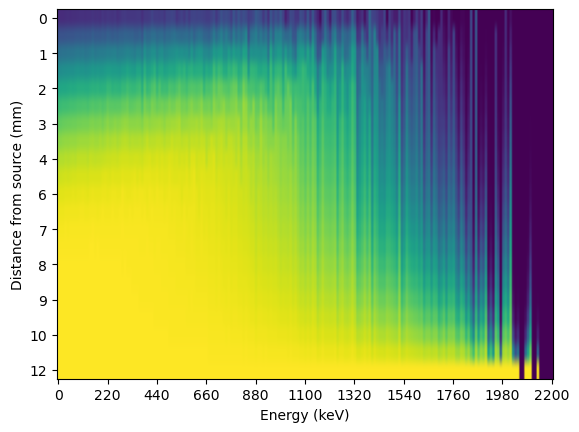

In [5]:
# make x in ints
x = np.arange(0, 2231, 10 * 2230 / 2000, dtype=np.uint)
plt.imshow(cpd[3:].reshape(21, -1, order="F"), aspect="auto")
plt.xticks(np.arange(0, 201, 20), x[::20])
# show y as integers 0-12 - make sure ints
plt.yticks(np.arange(0, 21, 2), np.arange(0, 13, 1.2).astype(int))
# label axes
plt.xlabel("Energy (keV)")
plt.ylabel("Distance from source (mm)")

(0.0, 1.0)

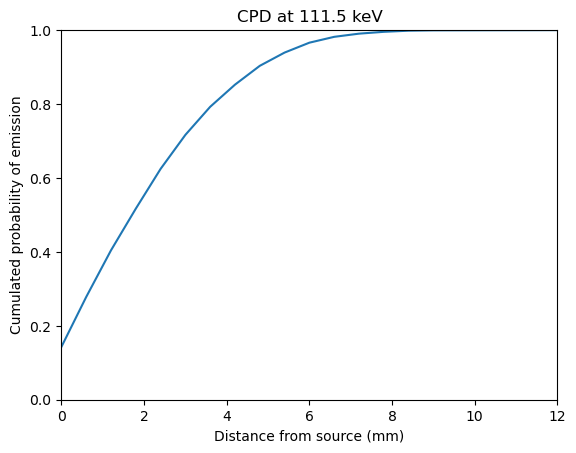

In [6]:
index = 10
x_ = np.arange(0, 12.5, 0.6)
plt.plot(x_, cpd[3 + index * 21 : 3 + (index + 1) * 21])
plt.title(f"CPD at {index * 10 * 2230 / 2000} keV")
plt.xlabel("Distance from source (mm)")
plt.ylabel("Cumulated probability of emission")
plt.xlim(0, 12)
plt.ylim(0, 1)

In [7]:
def fit_and_plot_gaussian(cpd, index, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    # x and y as in your snippet
    x = np.arange(0, 12, 0.6)  # 20 points
    y = np.diff(cpd[3 + index * 21 : 3 + (index + 1) * 21])  # 20 points

    # Gaussian model with baseline
    def gauss(x, A, mu, sigma, C):
        return A * np.exp(-0.5 * ((x - mu) / np.maximum(sigma, 1e-12)) ** 2) + C

    # Moment-based initialisation (robust to small baselines)
    C0 = np.percentile(y, 5)
    A0 = max(y.max() - C0, 1e-12)
    w = np.clip(y - C0, 0, None)
    if w.sum() <= 0:
        w = np.ones_like(x)
    mu0 = (x * w).sum() / w.sum()
    var0 = ((x - mu0) ** 2 * w).sum() / w.sum()
    sigma0 = float(np.sqrt(max(var0, (np.ptp(x) / 10.0) ** 2)))

    p0 = [A0, float(np.clip(mu0, x.min(), x.max())), sigma0, C0]

    # Try non-linear least squares; fall back to moments if SciPy missing
    popt = p0
    try:
        from scipy.optimize import curve_fit

        bounds = ([0, x.min(), 1e-6, -np.inf], [np.inf, x.max(), np.inf, np.inf])
        popt, _ = curve_fit(gauss, x, y, p0=p0, bounds=bounds, maxfev=20000)
    except Exception:
        pass  # keep moment-based popt

    # Plot
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, label="data")
    xx = np.linspace(x.min(), x.max(), 400)
    ax.plot(xx, gauss(xx, *popt), label=f"Gaussian fit, fwhm: {popt[2] * 2.2355:.2f}")
    ax.set_title(f"PDF at {index * 10 * 2230 / 2000} keV")
    ax.set_xlabel("Distance from source (mm)")
    ax.set_ylabel("Probability of emission")
    ax.legend()

    # Return fitted parameters
    return {"A": popt[0], "mu": popt[1], "sigma": popt[2], "C": popt[3]}

Text(0, 0.5, 'Probability of emission')

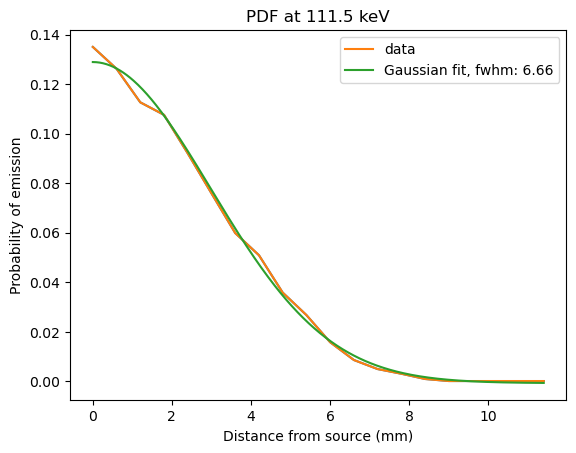

In [8]:
x = np.arange(0, 12, 0.6)
plt.plot(x, np.diff(cpd[3 + index * 21 : 3 + (index + 1) * 21]))
params = fit_and_plot_gaussian(cpd, index)
plt.title(f"PDF at {index * 10 * 2230 / 2000} keV")
plt.xlabel("Distance from source (mm)")
plt.ylabel("Probability of emission")

In [9]:
# create_window_file(
#    [50,75,36.84,60,140,220],
#    [140,225,126.16,80,160,240],
#    [0,0,0,0,0,0,0,0,0,0],
#    output_filename='AnyScan.win'
# )

In [10]:
ict = np.fromfile("anyscan.ict", dtype=np.uint16)
ict = ict.reshape(
    64,
    64,
    64,
)
ict = ict.astype(np.uint16)
ict.tofile("density.dmi")

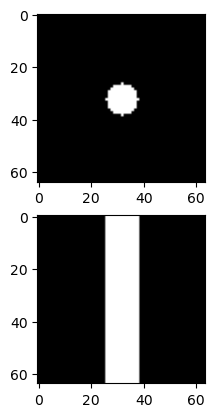

In [11]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(ict[32, :, :], cmap="gray")
ax[1].imshow(ict[:, 32, :], cmap="gray")

In [12]:
source = np.zeros_like(ict, dtype=np.uint16)
# central cube to 1 (2 voxels wide)
source[:, 31:33, 31:33] = 65535 / 10
source = source.astype(np.uint16)
source.tofile("source_simind_cyl.smi")

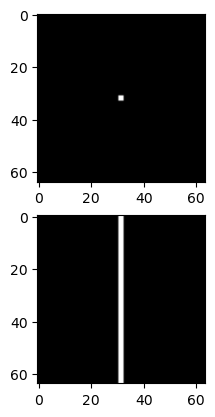

In [13]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(source[32, :, :], cmap="gray")
ax[1].imshow(source[:, 32, :], cmap="gray")

In [14]:
# import gaussian filter
from scipy.ndimage import gaussian_filter


smooth_source = gaussian_filter(source, sigma=6.91 / (2 * np.sqrt(2 * np.log(2))))

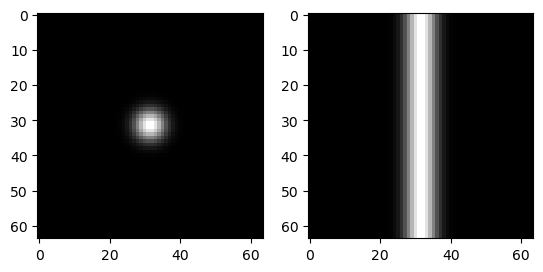

In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(smooth_source[32, :, :], cmap="gray")
ax[1].imshow(smooth_source[:, 32, :], cmap="gray")

In [16]:
smooth_source.tofile("source_cyl_gs.smi")

In [17]:
# subprocess.run(["simind", "AnyScan.", "/CC:ma-mlegp/FI:y90_frey.isd/MP"])

In [18]:
from sirf.STIR import AcquisitionData

from sirf_simind_connection.converters.simind_to_stir import SimindToStirConverter


converter = SimindToStirConverter()

# Define windows
windows = {
    "w1": "50_150",
    "w2": "75_225",
    "w3": "36_84_126_16",
    "w4": "60_80",
    "w5": "140_160",
    "w6": "220_240",
}

# Convert all files
for w in windows:
    converter.convert_file(f"anyscan_tot_{w}.h00", f"anyscan_tot_{w}.hs")
    converter.convert_file(f"anyscan_sca_{w}.h00", f"anyscan_sca_{w}.hs")

# Load totals, scatters, and compute primaries
sinos = {}
totals = {}
scatters = {}
for w, name in windows.items():
    totals[name] = AcquisitionData(f"anyscan_tot_{w}.hs")
    scatters[name] = AcquisitionData(f"anyscan_sca_{w}.hs")
    sinos[name] = totals[name] - scatters[name]  # primary

# Examples of access:
sino_50_150 = sinos["50_150"]
sino_75_225 = sinos["75_225"]
sino_36_84_126_16 = sinos["36_84_126_16"]
sino_60_80 = sinos["60_80"]
sino_140_160 = sinos["140_160"]
sino_220_240 = sinos["220_240"]

INFO: Successfully converted anyscan_tot_w1.h00 to anyscan_tot_w1.hs


INFO: Successfully converted anyscan_sca_w1.h00 to anyscan_sca_w1.hs
INFO: Successfully converted anyscan_tot_w2.h00 to anyscan_tot_w2.hs
INFO: Successfully converted anyscan_sca_w2.h00 to anyscan_sca_w2.hs
INFO: Successfully converted anyscan_tot_w3.h00 to anyscan_tot_w3.hs
INFO: Successfully converted anyscan_sca_w3.h00 to anyscan_sca_w3.hs
INFO: Successfully converted anyscan_tot_w4.h00 to anyscan_tot_w4.hs
INFO: Successfully converted anyscan_sca_w4.h00 to anyscan_sca_w4.hs
INFO: Successfully converted anyscan_tot_w5.h00 to anyscan_tot_w5.hs
INFO: Successfully converted anyscan_sca_w5.h00 to anyscan_sca_w5.hs
INFO: Successfully converted anyscan_tot_w6.h00 to anyscan_tot_w6.hs
INFO: Successfully converted anyscan_sca_w6.h00 to anyscan_sca_w6.hs


























In [19]:
import matplotlib.pyplot as plt

In [20]:
from sirf.STIR import AcquisitionData

In [21]:
import cmasher
import matplotlib.pyplot as plt
import numpy as np


def plot_sinos(sinos: dict):
    fig, ax = plt.subplots(
        3,
        3,
        figsize=(15, 12),  # extra row
        gridspec_kw={"height_ratios": [1, 1, 0.5]},  # make bottom row shorter
    )

    # top 2x3 images
    for i, (name, sino) in enumerate(sinos.items()):
        r, c = divmod(i, 3)
        im = ax[r, c].imshow(sino.as_array()[0, :, 1], cmap=cmasher.fall)
        ax[r, c].set_title(name + " keV")
        fig.colorbar(im, ax=ax[r, c], fraction=0.046, pad=0.04)

    # hide empty cell in bottom row
    for c in range(3):
        ax[2, c].remove()

    # create spanning axis for profiles
    ax_profile = fig.add_subplot(3, 1, 3)

    for name, sino in sinos.items():
        arr = sino.as_array()[0, :, 1]
        centre_line = arr[arr.shape[0] // 2, :]
        norm_line = centre_line / np.max(centre_line)
        ax_profile.plot(norm_line, label=name + " keV")

    ax_profile.set_title("Normalised central profiles")
    ax_profile.legend()
    ax_profile.set_xlabel("Pixel index")
    ax_profile.set_ylabel("Normalised intensity")

    fig.tight_layout()
    return fig

/tmp/ipykernel_1669808/3180745589.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_sinos(sinos).show()


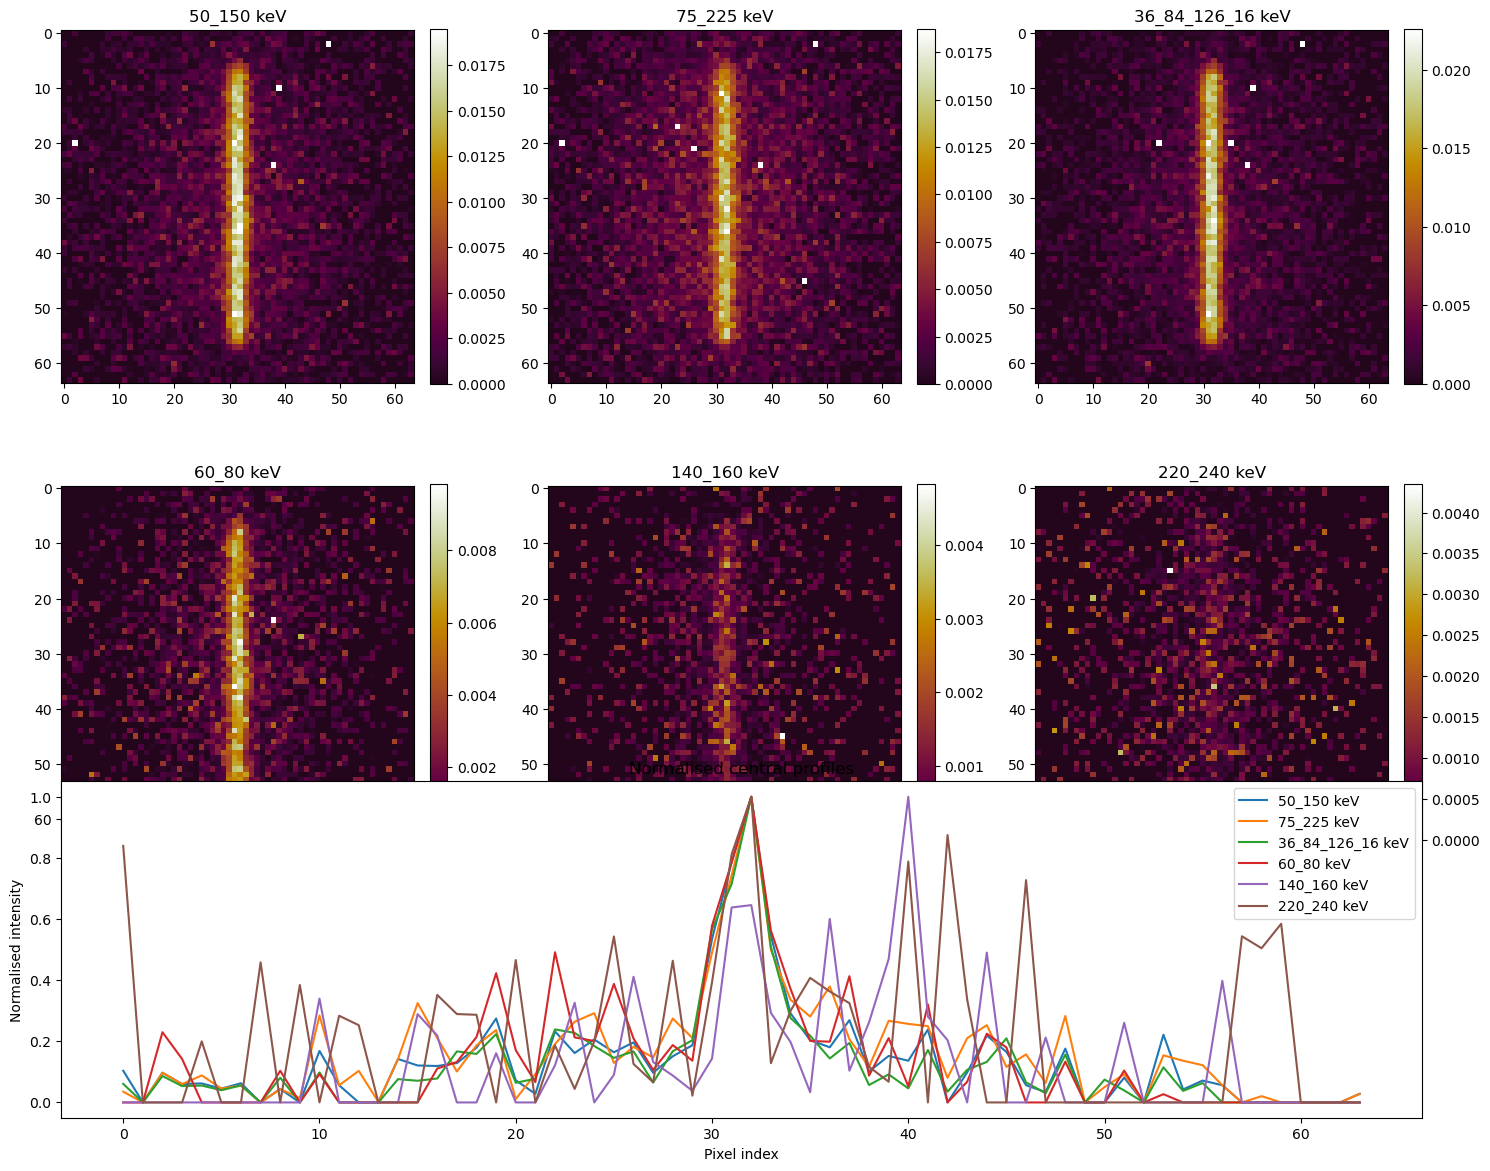

In [22]:
plot_sinos(sinos).show()

/tmp/ipykernel_1669808/2102292150.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_sinos(scatters).show()


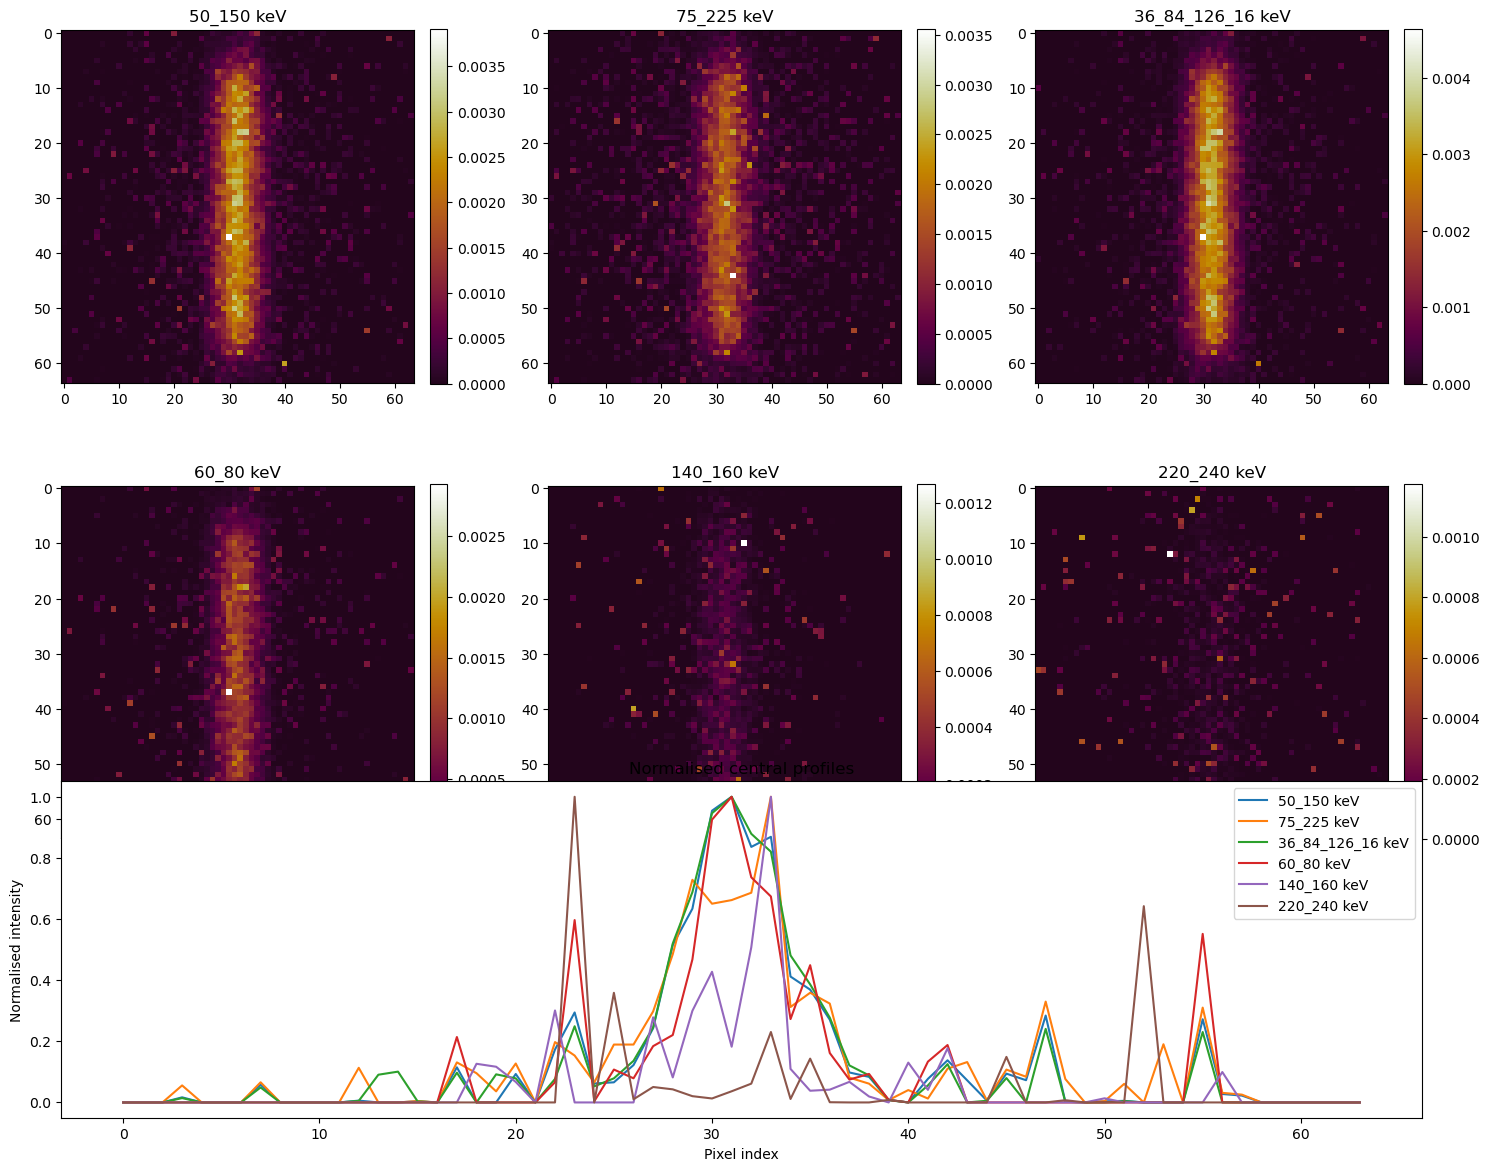

In [23]:
plot_sinos(scatters).show()

In [24]:
import pandas as pd

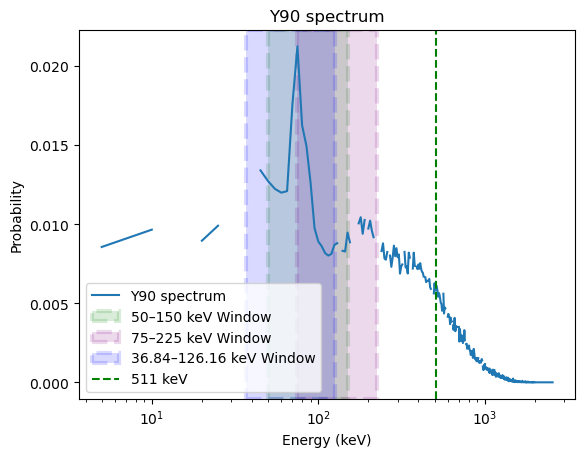

In [25]:
# parse as numeric and name the column up-front
spectrum = pd.read_csv(
    "/home/sam/working/sirf_simind_connection/sirf_simind_connection/configs/anyscan.s02",
    sep=";",
    index_col=0,
    header=None,
    names=["bin", "Y90 spectrum"],
)

# coerce strings (incl. blanks) to floats
spectrum["Y90 spectrum"] = pd.to_numeric(spectrum["Y90 spectrum"], errors="coerce")

# normalise to sum=1
spectrum["Y90 spectrum"] /= spectrum["Y90 spectrum"].sum()

# (optional) label axes when plotting
ax = spectrum.plot(legend=False)
ax.set_xlabel("bin")
ax.set_ylabel("normalised counts")

# shaded windows
ax.axvspan(
    50,
    150,
    facecolor="green",
    alpha=0.15,
    edgecolor="green",
    linestyle="--",
    linewidth=3,
    label="50–150 keV Window",
)
ax.axvspan(
    75,
    225,
    facecolor="purple",
    alpha=0.15,
    edgecolor="purple",
    linestyle="--",
    linewidth=3,
    label="75–225 keV Window",
)
ax.axvspan(
    36.84,
    126.16,
    facecolor="blue",
    alpha=0.15,
    edgecolor="blue",
    linestyle="--",
    linewidth=3,
    label="36.84–126.16 keV Window",
)

# single line at 511 keV
ax.axvline(511, color="green", linestyle="--", label="511 keV")

plt.xscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Probability")
plt.title(str(spectrum.columns[0]))
plt.legend()

/tmp/ipykernel_1669808/3767253252.py:2: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  spec = spectrum[10:].copy()


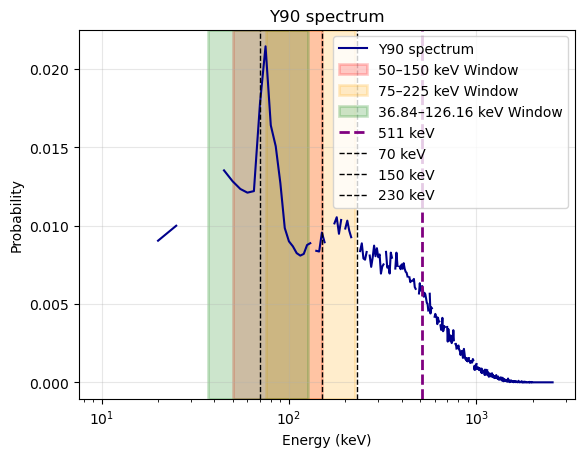

In [26]:
# normalise counts to sum=1 and label axes
spec = spectrum[10:].copy()
spec = spec.rename(columns={spec.columns[0]: "Y90 spectrum"})
spec["Y90 spectrum"] = spec["Y90 spectrum"] / spec["Y90 spectrum"].sum()

# Create the plot
ax = spec.plot(color="darkblue", linewidth=1.5)

# Shaded windows with distinct colors
ax.axvspan(
    50,
    150,
    facecolor="red",
    alpha=0.2,
    edgecolor="red",
    linestyle="-",
    linewidth=2,
    label="50–150 keV Window",
)
ax.axvspan(
    75,
    225,
    facecolor="orange",
    alpha=0.2,
    edgecolor="orange",
    linestyle="-",
    linewidth=2,
    label="75–225 keV Window",
)
ax.axvspan(
    36.84,
    126.16,
    facecolor="green",
    alpha=0.2,
    edgecolor="green",
    linestyle="-",
    linewidth=2,
    label="36.84–126.16 keV Window",
)

# 511 keV line
ax.axvline(511, color="purple", linestyle="--", linewidth=2, label="511 keV")
ax.axvline(70, color="black", linestyle="--", linewidth=1, label="70 keV")
ax.axvline(150, color="black", linestyle="--", linewidth=1, label="150 keV")
ax.axvline(230, color="black", linestyle="--", linewidth=1, label="230 keV")
# Formatting
plt.xscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Probability")
plt.title("Y90 spectrum")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks


def calculate_fwhm(x, y, peak_idx, smooth_window=3, max_peak_width=25):
    """
    Calculate FWHM for a peak at given index with optional smoothing.
    Height is measured from zero baseline.

    Parameters:
    x : array-like
        x-coordinates
    y : array-like
        y-coordinates (profile data)
    peak_idx : int
        Index of the peak in the arrays
    smooth_window : int, optional
        Window size for local averaging around peak (odd number)
    max_peak_width : int, optional
        Maximum distance (pixels) to search for peak boundaries from peak center

    Returns:
    tuple: (fwhm, left_x, right_x, half_max, peak_start, peak_end, smoothed_peak_height)
        FWHM value and boundary information, or Nones if calculation fails
    """
    try:
        # Apply local smoothing around the peak
        if smooth_window > 1:
            half_window = smooth_window // 2
            start_idx = max(0, peak_idx - half_window)
            end_idx = min(len(y), peak_idx + half_window + 1)

            # Create smoothed version of local region
            y_smooth = y.copy()
            for i in range(start_idx, end_idx):
                window_start = max(0, i - half_window)
                window_end = min(len(y), i + half_window + 1)
                y_smooth[i] = np.mean(y[window_start:window_end])

            peak_height = y_smooth[peak_idx]
            y_for_calc = y_smooth
        else:
            peak_height = y[peak_idx]
            y_for_calc = y

        # Height measured from zero baseline
        baseline = 0.0
        height_above_baseline = peak_height - baseline
        half_max = baseline + height_above_baseline / 2

        # Define search boundaries based on max_peak_width
        search_left = max(0, peak_idx - max_peak_width)
        search_right = min(len(y) - 1, peak_idx + max_peak_width)

        # Find peak boundaries by looking for points where signal approaches zero
        # Find peak start (left boundary) - look for where signal gets close to baseline
        peak_start = search_left
        for i in range(peak_idx - 1, search_left, -1):
            # Look for where signal drops to near baseline or stops decreasing
            if y[i] <= baseline + 0.1 * height_above_baseline:
                peak_start = i
                break
            elif i > search_left and y[i] >= y[i - 1]:  # stopped decreasing
                peak_start = i
                break

        # Find peak end (right boundary) - look for where signal gets close to baseline
        peak_end = search_right
        for i in range(peak_idx + 1, search_right):
            # Look for where signal drops to near baseline or stops decreasing
            if y[i] <= baseline + 0.1 * height_above_baseline:
                peak_end = i
                break
            elif i < search_right and y[i] >= y[i + 1]:  # stopped decreasing
                peak_end = i
                break

        # Find points where profile crosses half maximum within constrained range
        # Look left from peak (constrained by max_peak_width)
        left_idx = peak_idx
        while left_idx > search_left and y_for_calc[left_idx] > half_max:
            left_idx -= 1

        # Look right from peak (constrained by max_peak_width)
        right_idx = peak_idx
        while right_idx < search_right and y_for_calc[right_idx] > half_max:
            right_idx += 1

        # Check if we hit the search boundaries without finding half-max crossing
        if left_idx == search_left and y_for_calc[left_idx] > half_max:
            # Half-max crossing is outside our search range - use boundary
            left_x = x[search_left]
        elif left_idx < peak_idx:
            # Interpolate for precise half-max position
            x1, x2 = x[left_idx], x[left_idx + 1]
            y1, y2 = y_for_calc[left_idx], y_for_calc[left_idx + 1]
            left_x = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)
        else:
            left_x = x[left_idx]

        if right_idx == search_right and y_for_calc[right_idx] > half_max:
            # Half-max crossing is outside our search range - use boundary
            right_x = x[search_right]
        elif right_idx > peak_idx:
            # Interpolate for precise half-max position
            x1, x2 = x[right_idx - 1], x[right_idx]
            y1, y2 = y_for_calc[right_idx - 1], y_for_calc[right_idx]
            right_x = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)
        else:
            right_x = x[right_idx]

        fwhm = right_x - left_x
        return (
            fwhm if fwhm > 0 else None,
            left_x,
            right_x,
            half_max,
            peak_start,
            peak_end,
            peak_height,
        )

    except:
        return None, None, None, None, None, None, None


def plot_peak_profiles_arrays(
    arrays,
    *,
    labels=None,
    z_indices=(0, 10, 20, 50, 100),
    y_idx=64,
    figsize=(18, 3),
    peak_height=0.1,
    peak_distance=5,
    lower_threshold=0.05,
    show_fwhm=True,
    fwhm_offset=0.05,
    smooth_window=3,
    show_peak_markers=False,
    max_peak_width=25,
    pixel_spacing_mm=None,
):
    """
    Plot peak profiles with optional FWHM measurements.
    Height is measured from zero baseline.

    Parameters:
    arrays : list of arrays
        List of 3D arrays to plot profiles from
    labels : list of str, optional
        Labels for each array series
    z_indices : tuple, optional
        Z-indices to plot profiles for
    y_idx : int, optional
        Y-index to extract profile from
    figsize : tuple, optional
        Figure size
    peak_height : float, optional
        Minimum height for peak detection (relative to max)
    peak_distance : int, optional
        Minimum distance between peaks in pixels
    lower_threshold : float, optional
        Lower threshold as fraction of max value (filters noise)
    show_fwhm : bool, optional
        Whether to show FWHM annotations
    fwhm_offset : float, optional
        Vertical offset for FWHM text as fraction of peak height
    smooth_window : int, optional
        Window size for smoothing around peaks (odd number, 1=no smoothing)
    show_peak_markers : bool, optional
        Whether to show visual markers for peak definitions (half-max lines, etc.)
    max_peak_width : int, optional
        Maximum distance (pixels) from peak center to search for peak boundaries
    pixel_spacing_mm : float, optional
        Physical size of each pixel in mm. If provided, FWHM will be shown in mm instead of pixels
    """
    n_series = len(arrays)
    if labels is None:
        labels = [f"Series {i}" for i in range(n_series)]
    if len(labels) != n_series:
        raise ValueError("labels must match number of arrays")

    fig, axes = plt.subplots(1, len(z_indices), figsize=figsize, sharey=True)
    if len(z_indices) == 1:
        axes = [axes]

    colors = plt.cm.tab10(np.linspace(0, 1, n_series))

    for ax, z in zip(axes, z_indices):
        for i, (arr, lab) in enumerate(zip(arrays, labels)):
            # Extract profile
            profile = arr[0, y_idx, z]
            x = np.arange(len(profile))

            # Plot profile
            color = colors[i]
            ax.plot(x, profile, label=lab, color=color)

            if show_fwhm:
                # Apply lower threshold to filter noise
                profile_max = np.max(profile)
                threshold_mask = profile >= lower_threshold * profile_max
                filtered_profile = np.where(threshold_mask, profile, 0)

                # Find peaks on filtered profile
                height_threshold = peak_height * profile_max
                peaks, properties = find_peaks(
                    filtered_profile, height=height_threshold, distance=peak_distance
                )

                # Calculate and annotate FWHM for each peak
                for peak_idx in peaks:
                    fwhm_result = calculate_fwhm(
                        x, profile, peak_idx, smooth_window, max_peak_width
                    )
                    (
                        fwhm,
                        left_x,
                        right_x,
                        half_max,
                        peak_start,
                        peak_end,
                        smoothed_peak_height,
                    ) = fwhm_result

                    if fwhm is not None:
                        if show_peak_markers:
                            # Mark peak boundaries with vertical lines only
                            ax.axvline(
                                x[peak_start],
                                color=color,
                                linestyle=":",
                                alpha=0.6,
                                linewidth=1,
                            )
                            ax.axvline(
                                x[peak_end],
                                color=color,
                                linestyle=":",
                                alpha=0.6,
                                linewidth=1,
                            )

                            # Show FWHM span (only local, not across whole plot)
                            ax.plot(
                                [left_x, right_x],
                                [half_max, half_max],
                                color=color,
                                linewidth=3,
                                alpha=0.8,
                                solid_capstyle="round",
                            )

                            # Mark FWHM boundaries
                            ax.plot(
                                [left_x, left_x],
                                [half_max * 0.9, half_max * 1.1],
                                color=color,
                                linewidth=2,
                                alpha=0.8,
                            )
                            ax.plot(
                                [right_x, right_x],
                                [half_max * 0.9, half_max * 1.1],
                                color=color,
                                linewidth=2,
                                alpha=0.8,
                            )

                        # Mark the SMOOTHED peak value actually used (not raw noisy peak)
                        ax.plot(
                            x[peak_idx],
                            smoothed_peak_height,
                            "s",
                            color=color,
                            markersize=8,
                            markeredgecolor="white",
                            markeredgewidth=2,
                            zorder=6,
                            label="Estimated Peak" if peak_idx == peaks[0] else "",
                        )

                        # Also show the raw peak for comparison
                        ax.plot(
                            x[peak_idx],
                            profile[peak_idx],
                            "o",
                            color=color,
                            markersize=6,
                            alpha=0.5,
                            markeredgecolor="white",
                            markeredgewidth=1,
                            zorder=5,
                        )

                        # Annotate FWHM (convert to mm if pixel spacing provided)
                        if pixel_spacing_mm is not None:
                            fwhm_display = fwhm * pixel_spacing_mm
                            fwhm_units = "mm"
                        else:
                            fwhm_display = fwhm
                            fwhm_units = "px"

                        text_y = (
                            max(smoothed_peak_height, profile[peak_idx])
                            + fwhm_offset * profile_max
                        )
                        ax.annotate(
                            f"FWHM: {fwhm_display:.1f}{fwhm_units}",
                            xy=(x[peak_idx], smoothed_peak_height),
                            xytext=(x[peak_idx], text_y),
                            ha="center",
                            va="bottom",
                            fontsize=8,
                            color=color,
                            weight="bold",
                            bbox=dict(
                                boxstyle="round,pad=0.3",
                                facecolor="white",
                                edgecolor=color,
                                alpha=0.9,
                            ),
                        )

        ax.set_title(f"Projection {z}")
        ax.set_xlabel("x-pixel")
        ax.grid(alpha=0.3)

    axes[0].set_ylabel("Normalised counts")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=min(4, n_series))
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    return fig


# Alternative simpler version if you want to add FWHM to existing plots
def add_fwhm_to_profile(
    ax,
    x,
    y,
    color="red",
    peak_height=0.1,
    peak_distance=10,
    lower_threshold=0.00,
    smooth_window=1,
    show_peak_markers=True,
    max_peak_width=25,
    pixel_spacing_mm=None,
):
    """
    Add FWHM annotations to an existing profile plot.
    Height is measured from zero baseline.

    Parameters:
    ax : matplotlib axis
        Axis to add annotations to
    x : array-like
        x-coordinates
    y : array-like
        y-coordinates (profile data)
    color : str
        Color for annotations
    peak_height : float
        Minimum height for peak detection (relative to max)
    peak_distance : int
        Minimum distance between peaks
    lower_threshold : float
        Lower threshold as fraction of max value (filters noise)
    smooth_window : int, optional
        Window size for smoothing around peaks (odd number, 1=no smoothing)
    show_peak_markers : bool, optional
        Whether to show visual markers for peak definitions
    max_peak_width : int, optional
        Maximum distance (pixels) from peak center to search for peak boundaries
    pixel_spacing_mm : float, optional
        Physical size of each pixel in mm. If provided, FWHM will be shown in mm instead of pixels
    """
    profile_max = np.max(y)
    threshold_mask = y >= lower_threshold * profile_max
    filtered_profile = np.where(threshold_mask, y, 0)

    height_threshold = peak_height * profile_max
    peaks, _ = find_peaks(
        filtered_profile, height=height_threshold, distance=peak_distance
    )

    for peak_idx in peaks:
        fwhm_result = calculate_fwhm(x, y, peak_idx, smooth_window, max_peak_width)
        fwhm, left_x, right_x, half_max, peak_start, peak_end, smoothed_peak_height = (
            fwhm_result
        )

        if fwhm is not None:
            if show_peak_markers:
                # Mark peak boundaries with vertical lines only
                ax.axvline(x[peak_start], color=color, linestyle=":", alpha=0.6)
                ax.axvline(x[peak_end], color=color, linestyle=":", alpha=0.6)

                # Show FWHM span (local only)
                ax.plot(
                    [left_x, right_x],
                    [half_max, half_max],
                    color=color,
                    linewidth=3,
                    alpha=0.8,
                )
                ax.plot(
                    [left_x, left_x],
                    [half_max * 0.9, half_max * 1.1],
                    color=color,
                    linewidth=2,
                    alpha=0.8,
                )
                ax.plot(
                    [right_x, right_x],
                    [half_max * 0.9, half_max * 1.1],
                    color=color,
                    linewidth=2,
                    alpha=0.8,
                )

            # Mark smoothed peak (square) and raw peak (circle)
            ax.plot(
                x[peak_idx],
                smoothed_peak_height,
                "s",
                color=color,
                markersize=8,
                markeredgecolor="white",
                markeredgewidth=2,
                zorder=6,
            )
            ax.plot(
                x[peak_idx],
                y[peak_idx],
                "o",
                color=color,
                markersize=6,
                alpha=0.5,
                markeredgecolor="white",
                markeredgewidth=1,
                zorder=5,
            )

            # Annotate FWHM (convert to mm if pixel spacing provided)
            if pixel_spacing_mm is not None:
                fwhm_display = fwhm * pixel_spacing_mm
                fwhm_units = "mm"
            else:
                fwhm_display = fwhm
                fwhm_units = "px"

            text_y = max(smoothed_peak_height, y[peak_idx]) + 0.05 * profile_max
            ax.annotate(
                f"FWHM: {fwhm_display:.1f}{fwhm_units}",
                xy=(x[peak_idx], smoothed_peak_height),
                xytext=(x[peak_idx], text_y),
                ha="center",
                va="bottom",
                fontsize=8,
                color=color,
                weight="bold",
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    facecolor="white",
                    edgecolor=color,
                    alpha=0.9,
                ),
            )

In [28]:
sino_50_150.shape

(np.int32(1), np.int32(64), np.int32(2), np.int32(64))

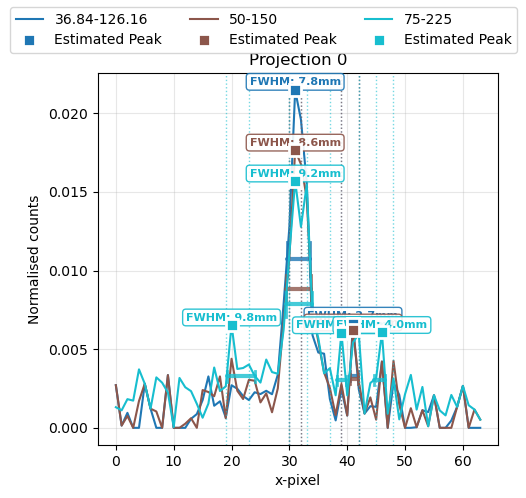

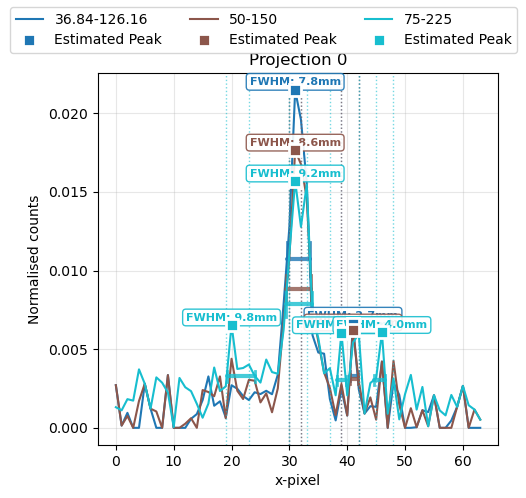

In [29]:
plot_peak_profiles_arrays(
    [
        sino_36_84_126_16.as_array(),
        sino_50_150.as_array(),
        sino_75_225.as_array(),
    ],
    labels=[
        "36.84-126.16",
        "50-150",
        "75-225",
    ],
    z_indices=[0],
    y_idx=32,
    figsize=(5, 5),
    fwhm_offset=0.01,
    peak_height=0.3,
    lower_threshold=0.1,
    max_peak_width=100,
    pixel_spacing_mm=2,
    show_peak_markers=True,
    smooth_window=1,
)
# plt.plot(smooth_source[32,32]/4000, color='b', linestyle=':')

In [30]:
np.sqrt(12.8**2 + 6.7**2 + 3.2**2) / 2.35

np.float64(6.296865934538821)

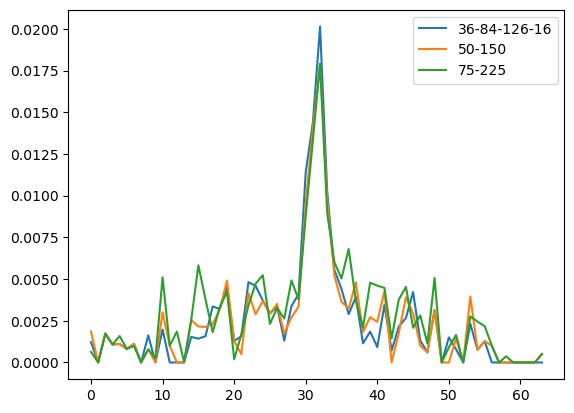

In [31]:
# plot line through sinogram
plt.plot(sino_36_84_126_16.as_array()[0, 32, 1], label="36-84-126-16")
plt.plot(sino_50_150.as_array()[0, 32, 1], label="50-150")
plt.plot(sino_75_225.as_array()[0, 32, 1], label="75-225")

plt.legend()